# GenMol Demo

In [1]:
!pip install rdkit python-dotenv pandas numpy matplotlib loguru py3dmol safe-mol datamol


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.4/495.4 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20

In [2]:
import random

import numpy as np
import safe as sf

from rdkit import Chem
from rdkit.Chem import AllChem

class Slicer:
    def __call__(self, mol):
        if isinstance(mol, str):
            mol = Chem.MolFromSmiles(mol)

        bonds = mol.GetSubstructMatches(Chem.MolFromSmarts('[*]-;!@[*]'))
        for bond in bonds:
            yield bond

class Utils:

    @staticmethod
    def cut(smiles):
        def cut_nonring(mol):
            if not mol.HasSubstructMatch(Chem.MolFromSmarts('[*]-;!@[*]')):
                return None

            bis = random.choice(mol.GetSubstructMatches(Chem.MolFromSmarts('[*]-;!@[*]')))  # single bond not in ring
            bs = [mol.GetBondBetweenAtoms(bis[0], bis[1]).GetIdx()]
            fragments_mol = Chem.FragmentOnBonds(mol, bs, addDummies=True, dummyLabels=[(1, 1)])

            try:
                return Chem.GetMolFrags(fragments_mol, asMols=True, sanitizeFrags=True)
            except ValueError:
                return None

        mol = Chem.MolFromSmiles(smiles)
        frags = set()

        for _ in range(3):
            frags_nonring = cut_nonring(mol)
            if frags_nonring is not None:
                frags |= set([Chem.MolToSmiles(f) for f in frags_nonring])

        return frags

    @staticmethod
    def attach(frag1, frag2):
        rxn = AllChem.ReactionFromSmarts('[*:1]-[1*].[1*]-[*:2]>>[*:1]-[*:2]')
        mols = rxn.RunReactants((Chem.MolFromSmiles(frag1), Chem.MolFromSmiles(frag2)))
        return None if len(mols) == 0 else Chem.MolToSmiles(mols[np.random.randint(len(mols))][0])

    @staticmethod
    def smiles2safe(smiles):
        return sf.SAFEConverter(ignore_stereo=True).encoder(smiles, allow_empty=True)

    @staticmethod
    def attachable_points(fragment):
        return sf.utils.list_individual_attach_points(Chem.MolFromSmiles(fragment), depth=3)

In [26]:
import pickle
from typing import List
import numpy as np

from rdkit import Chem

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from rdkit.Chem.QED import qed
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.DataStructs import TanimotoSimilarity
import ast
from google.colab import userdata
import os, shutil, requests
import pandas as pd

# SAFE <> SMILES conversion
import safe as sf
import datamol as dm

## Create Test SMILES, with "Fe" as exploration point

Ligand drawn with https://molview.org/ and exported as canonical SMILES string

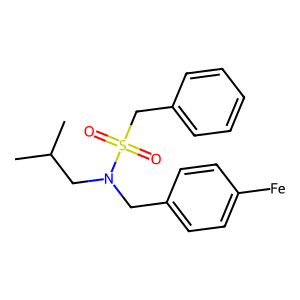

In [92]:
testsmiles = "CC(C)CN(Cc1ccc([Fe])cc1)[S](=O)(=O)Cc2ccccc2"
testmol = dm.to_mol(testsmiles)
display(dm.to_image(testmol))

In [93]:
safe_str = sf.encode(testmol)
print(f"SMILES: {testsmiles}")
print(f"SAFE:   {safe_str}\n represented using {len(safe_str.split('.'))} fragments")

SMILES: CC(C)CN(Cc1ccc([Fe])cc1)[S](=O)(=O)Cc2ccccc2
SAFE:   c15cc[c]([Fe])cc1.c16ccccc1.S4(=O)(=O)C6.CC(C)C2.N234.C35
 represented using 6 fragments


## Ensure `safe` and `datamol` are functioning correctly

Reconstruct the fragments to ensure reconstruction matches original input

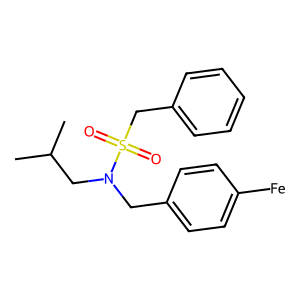

In [94]:
testreconstructed = dm.to_mol(safe_str)
display(dm.to_image(testreconstructed))

## Visualize `safe` deconstruction of SMILES into fragments

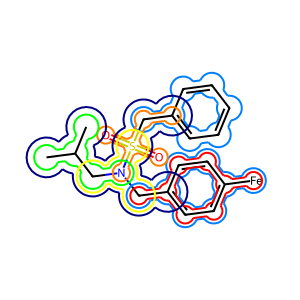

In [96]:
sf.to_image(safe_str)

## Edit SMILES of Parent Ligand to Enable `GenMol`

Replace `[Fe]` in SMILES string with `[2*]`

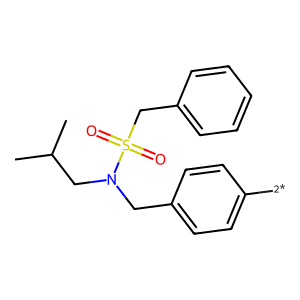

In [97]:
smiles = 'CC(C)CN(Cc1ccc([2*])cc1)[S](=O)(=O)Cc2ccccc2'
Draw.MolToImage(Chem.MolFromSmiles(smiles))

In [98]:
safe = Utils.smiles2safe(smiles)
safe

'c17ccc3cc1.c18ccccc1.S6(=O)(=O)C8.CC(C)C4.N456.C57'

## Create the `safe` SMILES with the Generation/Edit Point Included

In [110]:
smiles = safe + '.[*{15-30}]'
smiles

'c17ccc3cc1.c18ccccc1.S6(=O)(=O)C8.CC(C)C4.N456.C57.[*{15-30}]'

## Configure the `GenMol` API

In [111]:
API_KEY = userdata.get('API_KEY')
# print(API_KEY)

headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Accept": "application/json",
}

invoke_url = "https://health.api.nvidia.com/v1/biology/nvidia/genmol/generate"

session = requests.Session()

## Connect to the `GenMol` API and Collect the Results

In [112]:
payload = {
    "smiles": smiles,
    "num_molecules": 50,
    "temperature": 2,
    "noise": 1,
    "step_size": 1,
    "scoring": "QED"
}

# re-use connections
session = requests.Session()

response = session.post(invoke_url, headers=headers, json=payload)

response.raise_for_status()
result = response.json()
print(result)

{'status': 'success', 'molecules': [{'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': 'CC(C)CN(Cc1ccccc1)S(=O)(=O)Cc1ccccc1', 'score': 0.781}, {'smiles': '

## Visualize the Results

**Note:** only keeping the unique results, duplicates are omitted

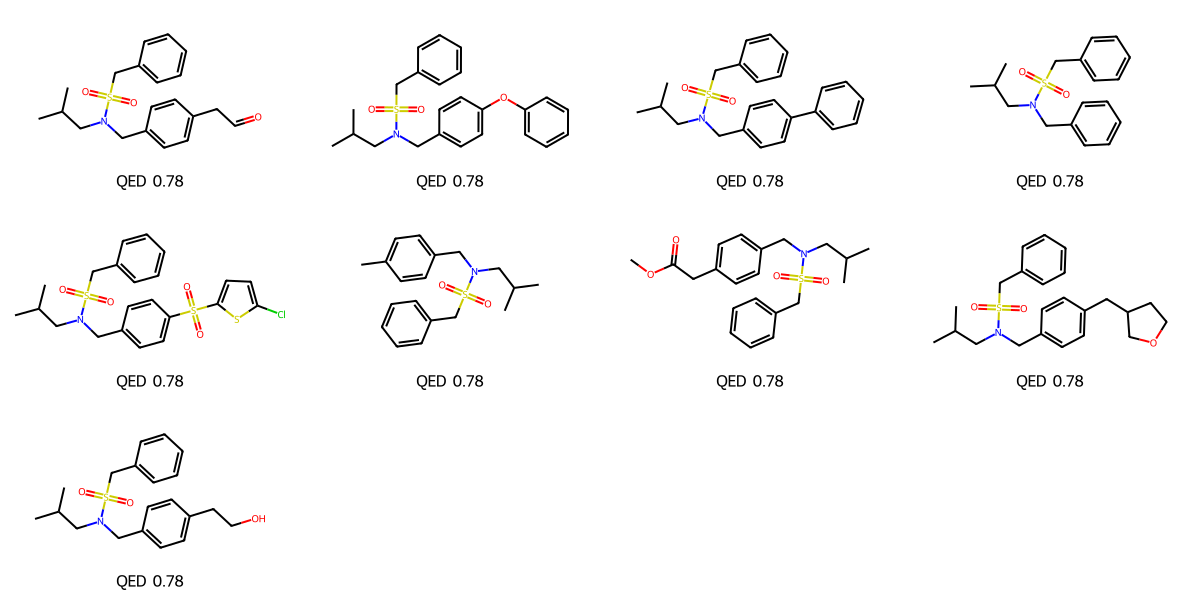

In [113]:
smiles_out, qed = [], []

for _ in result['molecules']:
  smiles_string = _['smiles']
  smiles_out.append(smiles_string)

for _ in result['molecules']:
  qed_score = _['score']
  qed.append(round(qed_score, 2))

unique_smiles = list(set(smiles_out))

ms = [Chem.MolFromSmiles(_) for _ in unique_smiles]
Draw.MolsToGridImage(ms, molsPerRow=4, subImgSize=(300, 200), legends=['QED ' + str(_) for _ in qed]) #